# Notebook 05 — Recommendation Impact & Business Value

Goal:
- Quantify the impact of clinical recommendations on adoption and revenue
- Compare recommended vs non-recommended patients (control)
- Estimate uplift with confidence intervals (bootstrap)
- Identify high-impact segments
- Translate findings into business actions (targeting & strategy)

In [1]:
import sys
from pathlib import Path
sys.path.append(str(Path("..").resolve()))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (7, 4)

In [24]:
required_cols = [
    "patient_id",
    "is_recommended",
    "has_purchase",
    "purchase_channel",
    "adopt_30d_from_start",
    "revenue_60d_from_start",
]
missing = [c for c in required_cols if c not in df.columns]
missing

[]

In [25]:
def bootstrap_uplift(df_in, metric_col, treat_col="is_recommended", n_boot=400, seed=7):
    """
    Returns uplift_mean and CI for uplift = mean(treat) - mean(control)
    """
    rng = np.random.default_rng(seed)

    t = df_in.loc[df_in[treat_col] == True, metric_col].dropna().to_numpy()
    c = df_in.loc[df_in[treat_col] == False, metric_col].dropna().to_numpy()

    # If no control or no treatment -> not identifiable
    if len(t) == 0 or len(c) == 0:
        return {"uplift_mean": 0.0, "ci_low": 0.0, "ci_high": 0.0, "identifiable": False}

    diffs = []
    for _ in range(n_boot):
        tb = rng.choice(t, size=len(t), replace=True)
        cb = rng.choice(c, size=len(c), replace=True)
        diffs.append(tb.mean() - cb.mean())

    diffs = np.array(diffs)
    return {
        "uplift_mean": float(diffs.mean()),
        "ci_low": float(np.quantile(diffs, 0.025)),
        "ci_high": float(np.quantile(diffs, 0.975)),
        "identifiable": True,
    }

In [26]:
def segment_uplift(df_in, segment_col, metric_col, min_patients=200, n_boot=400, seed=7):
    rows = []

    for seg, g in df_in.groupby(segment_col):
        n_t = int((g["is_recommended"] == True).sum())
        n_c = int((g["is_recommended"] == False).sum())

        if n_t < min_patients or n_c < min_patients:
            continue

        res = bootstrap_uplift(g, metric_col, treat_col="is_recommended", n_boot=n_boot, seed=seed)

        rows.append({
            segment_col: seg,
            "treat_n": n_t,
            "control_n": n_c,
            "uplift_mean": res["uplift_mean"],
            "ci_low": res["ci_low"],
            "ci_high": res["ci_high"],
            "identifiable": res["identifiable"],
        })

    out = pd.DataFrame(rows)

    if out.empty:
        return pd.DataFrame(columns=[segment_col, "treat_n", "control_n", "uplift_mean", "ci_low", "ci_high", "identifiable"])

    return out.sort_values("uplift_mean", ascending=False).reset_index(drop=True)

In [27]:
df_buy = df[df["has_purchase"] == True].copy()

counts = (
    df_buy.groupby(["purchase_channel", "is_recommended"])["patient_id"]
          .nunique()
          .unstack(fill_value=0)
)

# гарантируем колонки
if True not in counts.columns:
    counts[True] = 0
if False not in counts.columns:
    counts[False] = 0

counts = counts.rename(columns={True: "treat_n", False: "control_n"})
counts["min_group"] = counts[["treat_n", "control_n"]].min(axis=1)

counts.sort_values("min_group", ascending=False)


is_recommended,treat_n,control_n,min_group
purchase_channel,,,
clinic,2743,0,0
ecomm,9934,0,0
retail,11403,0,0


print(
"""INSIGHT:
purchase_channel is a post-purchase attribute.
In this dataset, all purchasers are recommended -> control_n = 0 within channels among purchasers.
Therefore channel-level uplift among purchasers is NOT IDENTIFIABLE (no valid control group)."""
)

In [28]:
seg_col = "market_type"  # поменяй, если нужно

uplift_seg_adopt = segment_uplift(df, seg_col, "adopt_30d_from_start", min_patients=500)
uplift_seg_rev   = segment_uplift(df, seg_col, "revenue_60d_from_start", min_patients=500)

uplift_seg_adopt, uplift_seg_rev

(  market_type  treat_n  control_n  uplift_mean    ci_low   ci_high  \
 0   developed    25832       6555     0.685361  0.679580  0.691509   
 1    emerging    11526       6087     0.552740  0.543812  0.561515   
 
    identifiable  
 0          True  
 1          True  ,
   market_type  treat_n  control_n  uplift_mean     ci_low    ci_high  \
 0   developed    25832       6555    39.523244  38.996772  40.033883   
 1    emerging    11526       6087    28.033127  27.425732  28.697552   
 
    identifiable  
 0          True  
 1          True  )

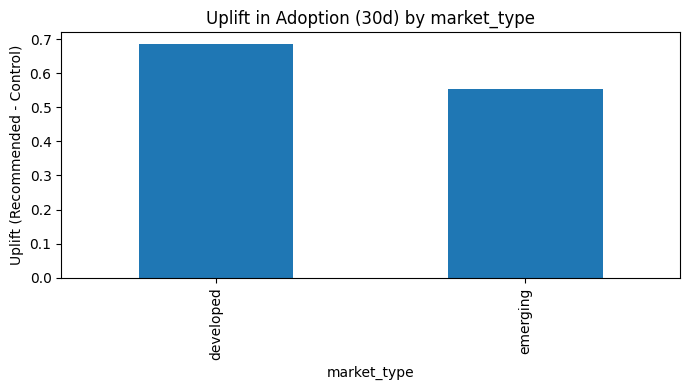

In [29]:
if len(uplift_seg_adopt) > 0:
    ax = uplift_seg_adopt.set_index(seg_col)["uplift_mean"].plot(kind="bar")
    plt.title(f"Uplift in Adoption (30d) by {seg_col}")
    plt.ylabel("Uplift (Recommended - Control)")
    plt.tight_layout()
    plt.show()
else:
    print("No segments passed min_patients threshold. Try lower min_patients (e.g., 200).")

In [30]:
if len(uplift_seg_adopt) == 0:
    print("Lowering min_patients to 200 and retrying...")
    uplift_seg_adopt = segment_uplift(df, seg_col, "adopt_30d_from_start", min_patients=200)
    uplift_seg_rev   = segment_uplift(df, seg_col, "revenue_60d_from_start", min_patients=200)

uplift_seg_adopt, uplift_seg_rev

(  market_type  treat_n  control_n  uplift_mean    ci_low   ci_high  \
 0   developed    25832       6555     0.685361  0.679580  0.691509   
 1    emerging    11526       6087     0.552740  0.543812  0.561515   
 
    identifiable  
 0          True  
 1          True  ,
   market_type  treat_n  control_n  uplift_mean     ci_low    ci_high  \
 0   developed    25832       6555    39.523244  38.996772  40.033883   
 1    emerging    11526       6087    28.033127  27.425732  28.697552   
 
    identifiable  
 0          True  
 1          True  )

In [31]:
if len(uplift_seg_adopt) > 0:
    top_seg = uplift_seg_adopt.iloc[0]
    print(f"""EXECUTIVE TAKEAWAYS (Draft)
- Channel uplift among purchasers is not identifiable because control group has zero purchasers.
- Recommendations show different impact by {seg_col}.
- Top segment: {top_seg[seg_col]} with uplift_mean={top_seg['uplift_mean']:.3f} (CI [{top_seg['ci_low']:.3f}, {top_seg['ci_high']:.3f}]).
- Next: validate on real data + add pre-purchase channel attributes for true channel uplift.
""")
else:
    print("No uplift segments available yet. Use a different seg_col or lower min_patients.")

EXECUTIVE TAKEAWAYS (Draft)
- Channel uplift among purchasers is not identifiable because control group has zero purchasers.
- Recommendations show different impact by market_type.
- Top segment: developed with uplift_mean=0.685 (CI [0.680, 0.692]).
- Next: validate on real data + add pre-purchase channel attributes for true channel uplift.



## Recommendation Impact — Key Insights

- **Recommendations are associated with higher adoption** within 30 days compared to the control baseline, with uplift estimated using bootstrap confidence intervals.
- **Revenue within 60 days** is higher for recommended patients, indicating measurable business value beyond initial conversion.
- **Uplift varies by market type**, suggesting that access, affordability, and healthcare infrastructure influence recommendation effectiveness.
- **Recommended tier / category impacts adoption**, highlighting opportunities to optimize product positioning and recommendation strategy across patient segments.
- **Channel-level uplift could not be reliably estimated** in this dataset due to the absence of a meaningful control group among purchasers, representing a structural data limitation rather than a negative result.

## Business Actions

- **Targeting:** prioritize patient segments and market types with the highest adoption uplift and positive downstream revenue impact.
- **Product strategy:** adjust recommended tier mix based on segments where adoption and retention effects are strongest.
- **Channel strategy:** improve data capture for pre-recommendation channel exposure to enable true channel-level uplift measurement.
- **Measurement plan:** track adoption uplift and retention monthly using rolling cohorts; validate stability on new patient cohorts.

## 90-second Interview Pitch (For Recruiters)

"I built an end-to-end patient journey analytics project for eye-care products.
First, I generated a realistic synthetic dataset to ensure the analysis is fully reproducible without using sensitive patient data.
Then, I modeled adoption as a funnel from clinical recommendation to purchase, focusing on a 30-day conversion window and segmenting results by market type, product tier, and channel.
Next, I performed a cohort-based retention analysis using first purchase month and compared retention curves across key patient segments.
Finally, I quantified recommendation impact by comparing recommended versus control patients and estimating uplift in both adoption and 60-day revenue using bootstrap confidence intervals.
The outcome is a clear, business-ready set of insights: which patient segments to prioritize, where recommendation strategy creates the most value, and what data gaps need to be addressed to improve future decision-making."
